In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from pdb import set_trace
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/Users/omarschall/online-meta/')
from utils import *

In [2]:
class Net(nn.Module):
    
    def __init__(self, layer_sizes, lr_init):
        super(Net, self).__init__()
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.n_params = 0
        for i in range(1, self.n_layers):
            attr = 'layer_{}'.format(i)
            setattr(self, attr, nn.Linear(layer_sizes[i-1],
                                          layer_sizes[i]))
            param_size = (layer_sizes[i-1] + 1) * layer_sizes[i]
            self.n_params += param_size
            
        self.param_sizes = [p.numel() for p in self.parameters()]
        self.param_shapes = [tuple(p.shape) for p in self.parameters()]
        self.param_cumsum = np.cumsum([0] + self.param_sizes)
            
        self.A = np.random.normal(0, 1, self.n_params)
        self.B = np.random.normal(0, 1, self.n_params)
        self.eta = np.ones(self.n_params)*lr_init
            
    def forward(self, x):
        x = x.view(-1, self.layer_sizes[0])
        for i_layer in range(1, self.n_layers):
            attr = 'layer_{}'.format(i_layer)
            layer = getattr(self, attr)
            x = layer(x)
            if i_layer < self.n_layers - 1:
                x = F.relu(x)
        
        return F.log_softmax(x, dim=1)
    
    def UORO_update_step(self, Q):

        self.nu = np.random.choice([-1, 1], Q.shape)
        grad = self.flatten_array([p.grad.data.numpy() for p in self.parameters()])
        
        self.M_projection = self.nu * grad
        self.A_forwards = self.A - self.eta * Q
        A_norm = norm(self.A_forwards)
        B_norm = norm(self.B)
        M_norm = norm(self.M_projection)
        self.rho_0 = np.sqrt(B_norm/A_norm)
        self.rho_1 = np.sqrt(M_norm/np.sqrt(len(self.nu)))
        
        self.A = self.rho_0 * self.A_forwards + self.rho_1 * self.nu
        self.B = (1/self.rho_0) * self.B + (1/self.rho_1) * self.M_projection
        
    def get_updated_eta(self, mlr, test_grad):
        
        test_grad = self.flatten_array(test_grad)
        self.eta -= mlr*(test_grad.dot(self.A)) * self.B
        self.eta = np.maximum(0, self.eta)
        
        return np.copy(self.unflatten_array(self.eta))
    
    def flatten_array(self, X):
        """Takes list of arrays in natural shape of the network parameters
        and returns as a flattened 1D numpy array."""
        
        return np.concatenate([x.flatten() for x in X])
            
    def unflatten_array(self, X):
        """Takes flattened array and returns in natural shape for network
        parameters."""
        
        N = self.param_cumsum
        
        return [np.reshape(X[N[i]:N[i+1]], s) for i, s in enumerate(self.param_shapes)]
        
        

In [3]:
import torch
from torch.optim.optimizer import Optimizer
from itertools import tee

class SGD_Multi_LR(Optimizer):

    def __init__(self, params, lr_init=0.005):
        
        params, params_copy = tee(params)
        LR = [lr_init*torch.ones(p.shape) for p in params]
        defaults = dict(lr=LR)
        super(SGD_Multi_LR, self).__init__(params_copy, defaults)

    def __setstate__(self, state):
        super(SGD_Multi_LR, self).__setstate__(state)

    def step(self):
        """Performs a single optimization step."""

        for group in self.param_groups:
            for p, lr in zip(group['params'], group['lr']):
                if p.grad is None:
                    continue
                d_p = p.grad.data
                p_change = -lr * d_p
                p.data.add_(p_change)

In [6]:
def train(model, train_loader, test_loader, optimizer, epoch, r=0.001, mlr=0.00001,
          report_interval=1000):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % report_interval == 0 and batch_idx > 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        ### --- METALEARNING --- ###
        
        #Approximate the Hessian
        A = model.unflatten_array(model.A)
        
        model_plus = copy(model)
        for p, a in zip(model_plus.parameters(), A):
            perturbation = torch.from_numpy(r*a).type(torch.FloatTensor)
            p.data += perturbation
        
        model_plus.train()
        output = model_plus(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        
        model_minus = copy(model)
        for p, a in zip(model_minus.parameters(), A):
            p.data -= torch.from_numpy(r*a).type(torch.FloatTensor)
        
        model_minus.train()
        output = model_plus(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        
        g_plus = [p.grad.data for p in model_plus.parameters()]
        g_minus = [p.grad.data for p in model_minus.parameters()]
        Q = (model.flatten_array(g_plus) - model.flatten_array(g_minus))/(2*r)
        
        test_grad = get_test_grad(model, test_loader=test_loader)
        model.UORO_update_step(Q)
        new_eta = model.get_updated_eta(mlr, test_grad=test_grad)
        
        #set_trace()
        
        for lr, eta in zip(optimizer.param_groups[0]['lr'], new_eta):
            lr.data = torch.from_numpy(eta).type(torch.FloatTensor)

In [7]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
def get_test_grad(model, test_loader):
    test_model = copy(model)
    test_model.train()
    for data, target in test_loader:
        #set_trace()
        #TODO: MAKE THIS SAMPLE FROM DIFFERENT PARTS OF THE TEST DATA!
        output = test_model(data)
        test_loss = F.nll_loss(output, target)
        test_loss.backward()
        break
        
    return [p.grad.data.numpy() for p in test_model.parameters()]

In [11]:
batch_size = 200
test_batch_size = 100
epochs = 5
lr = 1e-1

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)


model = Net([784, 1000, 200, 10], lr_init=lr)
optimizer = SGD_Multi_LR(model.parameters(), lr_init=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, train_loader, test_loader, optimizer, epoch, mlr=0.00005)
    test(model, test_loader)


Test set: Average loss: 0.2049, Accuracy: 9388/10000 (94%)


Test set: Average loss: 0.1306, Accuracy: 9605/10000 (96%)


Test set: Average loss: 0.1028, Accuracy: 9677/10000 (97%)


Test set: Average loss: 0.0867, Accuracy: 9729/10000 (97%)


Test set: Average loss: 0.0748, Accuracy: 9768/10000 (98%)



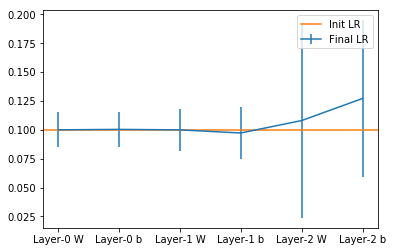

In [10]:
mean_LRs = [float(LR.mean()) for LR in optimizer.param_groups[0]['lr']]
std_LRs = [float(LR.std()) for LR in optimizer.param_groups[0]['lr']]
plt.errorbar(range(len(mean_LRs)), mean_LRs, yerr=std_LRs)
plt.axhline(y=lr, color='C1')
param_types = ['W', 'b']
labels = ['Layer-{} {}'.format(i//2, param_types[i%2]) for i in range(len(mean_LRs))]
plt.xticks(range(len(mean_LRs)), labels)
plt.legend(['Init LR', 'Final LR'])
#plt.ylim([0,0.1])

In [59]:
float(optimizer.param_groups[0]['lr'][0].mean())

0.00999774131923914